<a href="https://colab.research.google.com/github/valeriopagliarino/Electronics-2021-UNITO/blob/main/analysis/2_OPA_integ_deriv_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis: Introduction and OPA amplifiers
### October 5th 2021
<p>
Authors: <b> Stefano Barbero, Valerio Pagliarino, Matteo Barbagiovanni, Federico Malnati </b> <p>Electronics Laboratory 2021 - Department of Physics - University of Turin <p>
Date: 05/10/2021

1. OPA integrator
2. OPA differentiator
3. OPA log amplifier


OPA: LM471CV (https://www.ti.com/lit/ds/symlink/lm741.pdf)


## Configuration

### Clone the GIT

In [1]:
!rm -r ./sample_data
import os
from getpass import getpass
user = input('GitHub user')
mail = input('GitHub email')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/valeriopagliarino/Electronics-2021-UNITO.git
!git config --global user.email user
!git config --global user.name mail

GitHub uservaleriopagliarino
GitHub emailvalerio.pagliarino@edu.unito.it
GitHub password··········
Cloning into 'Electronics-2021-UNITO'...
remote: Enumerating objects: 695, done.
remote: Counting objects: 100% (695/695), done.
remote: Compressing objects: 100% (525/525), done.
remote: Total 695 (delta 333), reused 376 (delta 148), pack-reused 0
Receiving objects: 100% (695/695), 27.54 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (333/333), done.


### Install environment

In [2]:
exec(open("./Electronics-2021-UNITO/analysis/ROOT-config.py").read())

Start config for JupyROOT Env. on Google Coolab - It takes about 3 minutes
WGET...
Done.
UNZIP...
TAR...
APT...
Installation completed.
Shared objects loaded.
Welcome to JupyROOT 6.14/04
Completed!


### Importa moduli [no COLAB]

In [ ]:
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from matplotlib import pyplot as plt

from uncertainties import ufloat
import uncertainties.umath

import pickle

import ROOT # Per COLAB importato da ROOT-config.py

### Importa moduli [COLAB]

In [3]:
%cd /content/
!pip3 install uncertainties
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from uncertainties import ufloat
import uncertainties.umath
from matplotlib import pyplot as plt
import pickle

#Pickle with dict of Numpy arrays

/content
     |████████████████████████████████| 98 kB 4.0 MB/s 


### Funzioni per l'importazione file Tektronix

In [4]:
import csv

def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

## OPA log-amplifier XY plot

/content


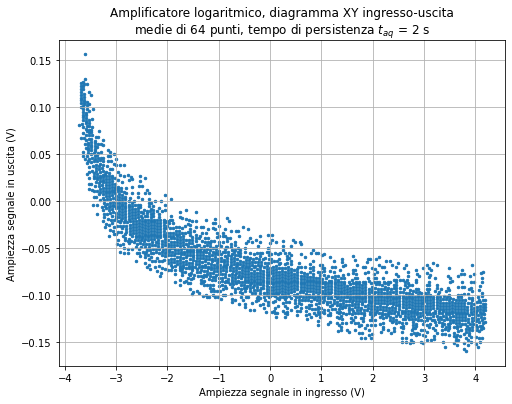

In [26]:
%cd /content

logXY = pd.read_csv("./Electronics-2021-UNITO/data-source/5-10-21/OPA_log_XY_plot/TEK00XY01.csv")

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(logXY.to_numpy().transpose()[0], logXY.to_numpy().transpose()[1], s=6)

ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Amplificatore logaritmico, diagramma XY ingresso-uscita\nmedie di 64 punti, tempo di persistenza $t_{aq}$ = 2 s')

ax.grid()

plt.savefig("./Electronics-2021-UNITO/analysis/output/OPA-log-AMP-XY.pdf")

## OPA integrator - with discharging resistor

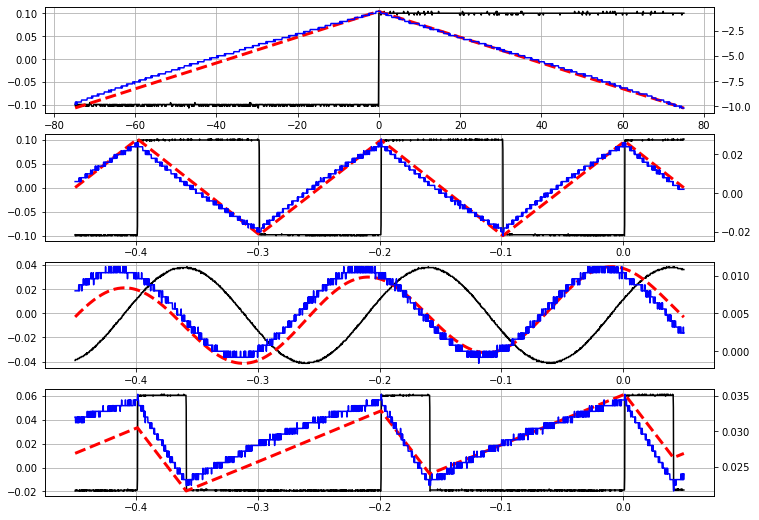

In [96]:
in_step    = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_step/F0002CH1.CSV')
out_step   = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_step/F0002CH2.CSV')
in_square  = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_square_wave/F0005CH1.CSV')
out_square = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_square_wave/F0005CH2.CSV')
in_sine    = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_sine/F0007CH1.CSV')
out_sine   = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_sine/F0007CH2.CSV')
in_pmod    = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_pulsemod/F0008CH1.CSV')
out_pmod   = openTek('./Electronics-2021-UNITO/data-source/5-10-21/OPA_integ_with_res_pulsemod/F0008CH2.CSV')

crop_in1 = 500
crop_out1 = 2000

crop_in2 = 0
crop_out2 = 2500

crop_in3 = 0
crop_out3 = 2500

time_in_step    = in_step['Data'].to_numpy().transpose()[0][crop_in1:crop_out1]   * 1000   
time_out_step   = out_step['Data'].to_numpy().transpose()[0][crop_in1:crop_out1]   * 1000  
time_in_square  = in_square['Data'].to_numpy().transpose()[0] * 1000 
time_out_square = out_square['Data'].to_numpy().transpose()[0] * 1000
time_in_sine    = in_sine['Data'].to_numpy().transpose()[0][crop_in2:crop_out2] * 1000   
time_out_sine   = out_sine['Data'].to_numpy().transpose()[0][crop_in2:crop_out2] * 1000    
time_in_pmod    = in_pmod['Data'].to_numpy().transpose()[0][crop_in3:crop_out3] * 1000   
time_out_pmod   = out_pmod['Data'].to_numpy().transpose()[0][crop_in3:crop_out3] * 1000  


sig_in_step     = in_step['Data'].to_numpy().transpose()[1][crop_in1:crop_out1]   
sig_out_step    = out_step['Data'].to_numpy().transpose()[1][crop_in1:crop_out1]  
sig_in_square   = in_square['Data'].to_numpy().transpose()[1] 
sig_out_square  = out_square['Data'].to_numpy().transpose()[1]
sig_in_sine     = in_sine['Data'].to_numpy().transpose()[1][crop_in2:crop_out2]   
sig_out_sine    = out_sine['Data'].to_numpy().transpose()[1][crop_in2:crop_out2] 
sig_in_pmod     = in_pmod['Data'].to_numpy().transpose()[1][crop_in3:crop_out3]   
sig_out_pmod    = out_pmod['Data'].to_numpy().transpose()[1][crop_in3:crop_out3]  

sig_in_step     = sig_in_step   - sig_in_step.mean() 
sig_in_square   = sig_in_square - sig_in_square.mean() 
sig_in_sine     = sig_in_sine   - sig_in_sine.mean() 
sig_in_pmod     = sig_in_pmod   - sig_in_pmod.mean() 
 


fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(12, 9))

ax2 = []
for ax_2 in ax:
  ax2.append(ax_2.twinx())

def mm_norm(nn, ref):
  maxv = max(ref)
  minv = min(ref)
  return ((nn - min(nn)) / (max(nn) - min(nn))) * (maxv - minv) + minv


step_quadrature = sig_in_step.cumsum() * -1.
square_quadrature = sig_in_square.cumsum() * -1.
sine_quadrature = sig_in_sine.cumsum() * -1. + 1
pmod_quadrature = (sig_in_pmod).cumsum() * -1. 

ax[0].plot(time_in_step, sig_in_step, color = "black", label = "Gradino")
ax2[0].plot(time_in_step, mm_norm(step_quadrature, sig_out_step) , color = "red", linestyle = "--", linewidth=3)
ax2[0].plot(time_out_step, sig_out_step, color = "blue", label = "Integrale")

ax[1].plot(time_in_square, sig_in_square, color = "black", label = "Onda quadra")
ax2[1].plot(time_in_square, mm_norm(square_quadrature, sig_out_square) , color = "red", linestyle = "--", linewidth=3)
ax2[1].plot(time_out_square, sig_out_square, color = "blue", label = "Integrale")

ax[2].plot(time_in_sine, sig_in_sine, color = "black", label = "Sinusoide")
ax2[2].plot(time_in_sine, mm_norm(sine_quadrature, sig_out_sine) , color = "red", linestyle = "--", linewidth=3)
ax2[2].plot(time_out_sine, sig_out_sine, color = "blue", label = "Integrale")

ax[3].plot(time_in_pmod, sig_in_pmod, color = "black", label = "Treno di impulsi")
ax2[3].plot(time_in_pmod, mm_norm(pmod_quadrature, sig_out_pmod) , color = "red", linestyle = "--", linewidth=3)
ax2[3].plot(time_out_pmod, sig_out_pmod, color = "blue", label = "Integrale")


for ax_ in ax:
  ax_.grid()
  #ax_.legend(loc="upper left")



plt.savefig("./Electronics-2021-UNITO/analysis/output/OPA-integ-with-res.pdf")

## Commit changes

In [ ]:
%cd /content/Electronics-2021-UNITO/
!git pull
!git add .
!git commit -m "Plots from data analysis"
!git push 

/content/Electronics-2021-UNITO
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/valeriopagliarino/Electronics-2021-UNITO
   6f22bae..033249f  main       -> origin/main
Updating 6f22bae..033249f
Fast-forward
 analysis/1_Introduction_and_OPA_amplifiers.ipynb | 68 ++++++++++++------------
 1 file changed, 33 insertions(+), 35 deletions(-)
[main e7c0d08] Plots from data analysis
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 analysis/output/OPA-open-loop-slew-rate.pdf
Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 110.19 KiB | 22.04 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/valeriop